In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch

In [3]:
from utils import MnistData
from models import ModelManager, ModelType

In [51]:
model_loaded = ModelManager.get_trained(ModelType.MnistCnnPatt)


In [5]:
data = MnistData(True)

In [6]:
def max_norm(t: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.abs(t))

In [57]:
def solve_for(model, benign_image, label, c_lambda):
    step_size = 1e-2
    #adv = benign_image + (torch.rand(benign_image.shape) - 0.5) * 1e-1
    #adv = benign_image
    adv = torch.zeros(benign_image.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    norm = nn.L1Loss(reduction='sum')
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = norm(adv.unsqueeze(0), benign_image.unsqueeze(0)) \
            - c_lambda * loss_fn(model(adv.unsqueeze(0)), torch.Tensor([label]).type(torch.long))
        loss.backward()
        new_adv = MnistData.clip_for_image(adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1))
        adv = new_adv
    if MnistData.get_prediction(model, adv)[0] != label:
        return adv
    return None
    


In [73]:
def cw_attack(model, benign_image, label) -> torch.Tensor:
    adv = None
    c_lambda = 1e-1
    while adv is None:
        #print(f'\tc_lamda = {c_lambda}')
        adv = solve_for(model, benign_image, label, c_lambda)
        c_lambda *= 1.1
    #print(f'\tc_lamda = {c_lambda}')
    return adv
        


In [74]:
benign_images, labels = data.get_training_batch(10)
altered_training_images = []

for i in range(len(labels)):
    print(f'--- {i} ---')
    benign_image = benign_images[i]
    #MnistData.display(benign_image)
    label = labels[i]
    altered_training_images.append(cw_attack(model_loaded, benign_image, label))

#altered_training_images = torch.Tensor(altered_training_images)

--- 0 ---
	c_lamda = 0.9849732675807628
--- 1 ---
	c_lamda = 0.740024994425817
--- 2 ---
	c_lamda = 0.6115909044841462
--- 3 ---
	c_lamda = 0.5054470284992942
--- 4 ---
	c_lamda = 1.3109994191499956
--- 5 ---
	c_lamda = 0.6727499949325609
--- 6 ---
	c_lamda = 1.3109994191499956
--- 7 ---
	c_lamda = 0.3452271214393102
--- 8 ---
	c_lamda = 0.5559917313492238
--- 9 ---
	c_lamda = 0.2143588810000001


In [75]:
possible_adversarials = MnistData.get_adversarials(model_loaded, benign_images, labels, altered_training_images)
len(possible_adversarials)

10

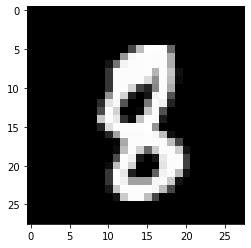

+++++


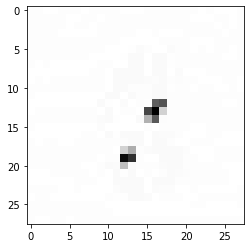

=====


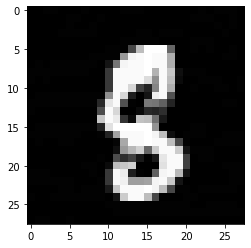

Label: 8, Prediction: 5, Confidence: 0.669967532157898
Original prediction: 8, Original confidence: 1.0


In [78]:
MnistData.show_adversarial(possible_adversarials, benign_images, altered_training_images, 7)